# Data Preperation

In [ ]:
!pip install pandas
!pip install openslide-bin
!pip install scikit-learn
!pip install matplotlib
!pip install numpy
!pip install seaborn
!pip install tqdm

In [ ]:
!pip install torch
!pip install torchvision
!pip install Pillow
!pip install transformers
!pip install staintools

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy._core.fromnumeric import shape
import seaborn as sns
from glob import glob
import re
import openslide
from tqdm import tqdm
import xml.etree.ElementTree as ET
from multiprocessing import Pool, cpu_count
import gc


In [ ]:
import math
from pathlib import Path
from PIL import Image
import openslide
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.models as models
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [2]:
# Define base path
base_dir = "/scratch3/users/chantelle/tcga_cesc_data"
processed_dir = "/scratch3/users/chantelle/tcga_cesc_data/processed"
# Define subfolders
paths = {
    "clinical": os.path.join(base_dir, "mutation"),
    "cnv": os.path.join(base_dir, "Clincal"),
    "snv": os.path.join(base_dir, "MAF"),
    "transcriptome": os.path.join(base_dir, "CNV"),
    "wsi" : os.path.join(base_dir, "wsi"),
    "output" : os.path.join(base_dir, "processed"),
    "sample_sheet" : "/users/chantelle/gdc_sample_sheet.2025-10-10.tsv",
    "methylation" : os.path.join(base_dir, "methylation")
}

# Check folders exist
for key, path in paths.items():
    print(f"{key}: {os.path.exists(path)}")

clinical: True
cnv: True
snv: True
transcriptome: True
wsi: True
output: True
sample_sheet: True
methylation: True


### Clincal data Preperation

In [5]:
import pandas as pd, numpy as np
clinical = pd.read_csv("/scratch3/users/chantelle/tcga_cesc_data/CNV/clinical.tsv", sep="\t")
clinical = clinical.replace({"'--": np.nan, "Not Reported": np.nan, "not reported": np.nan}).copy()

clinical.columns.tolist()

/tmp/ipykernel_2925404/1898804827.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinical = clinical.replace({"'--": np.nan, "Not Reported": np.nan, "not reported": np.nan}).copy()


['project.project_id',
 'cases.case_id',
 'cases.consent_type',
 'cases.days_to_consent',
 'cases.days_to_lost_to_followup',
 'cases.disease_type',
 'cases.index_date',
 'cases.lost_to_followup',
 'cases.primary_site',
 'cases.submitter_id',
 'demographic.age_at_index',
 'demographic.age_is_obfuscated',
 'demographic.cause_of_death',
 'demographic.cause_of_death_source',
 'demographic.country_of_birth',
 'demographic.country_of_residence_at_enrollment',
 'demographic.days_to_birth',
 'demographic.days_to_death',
 'demographic.demographic_id',
 'demographic.education_level',
 'demographic.ethnicity',
 'demographic.gender',
 'demographic.marital_status',
 'demographic.occupation_duration_years',
 'demographic.population_group',
 'demographic.premature_at_birth',
 'demographic.race',
 'demographic.submitter_id',
 'demographic.vital_status',
 'demographic.weeks_gestation_at_birth',
 'demographic.year_of_birth',
 'demographic.year_of_death',
 'diagnoses.adrenal_hormone',
 'diagnoses.age_at_

In [10]:
print(clinical[["treatments.days_to_treatment_start", "treatments.days_to_treatment_end"]])
clinical["treatments.days_to_treatment_end"].describe()

     treatments.days_to_treatment_start treatments.days_to_treatment_end
0                                   NaN                              NaN
1                                   NaN                              NaN
2                                   NaN                              NaN
3                                   NaN                              NaN
4                                   NaN                              NaN
...                                 ...                              ...
1521                                NaN                              NaN
1522                                NaN                              NaN
1523                                153                              155
1524                                155                              155
1525                                NaN                              NaN

[1526 rows x 2 columns]


count     421
unique    178
top        90
freq       10
Name: treatments.days_to_treatment_end, dtype: object

In [7]:
# Select columns
clinical_filtered = clinical[[
    "cases.submitter_id",
    "cases.disease_type",
    "demographic.cause_of_death",
    "diagnoses.classification_of_tumor",
    "treatments.treatment_outcome",
    "treatments.treatment_type"
]]

# Rename for consistency
clinical_filtered.rename(columns={
    "cases.submitter_id": "case_id",
    "cases.disease_type": "subtype",
    "demographic.cause_of_death": "cause_of_death",
    "diagnoses.classification_of_tumor": "classification_of_tumor",
    "treatments.treatment_type": "treatment_type",
    "treatments.treatment_outcome": "treatment_outcome"
}, inplace=True)

# === Normalise histological subtype ===
def normalize_subtype(x):
    if pd.isna(x):
        return np.nan
    if "Squamous Cell Neoplasms" in x:
        return "Squamous"
    elif "Adenomas and Adenocarcinomas" in x:
        return "Adenocarcinoma"
    else:
        return "Other"

clinical_filtered["subtype"] = clinical_filtered["subtype"].apply(normalize_subtype)

# === Normalise cause of death ===
def normalize_cause_of_death(y):
    if pd.isna(y):
        return np.nan
    if "Cancer Related" in y:
        return "Cancer Related"
    else:
        return "Other"

clinical_filtered["cause_of_death"] = clinical_filtered["cause_of_death"].apply(normalize_cause_of_death)

# Drop duplicate case_ids
clinical_filtered = clinical_filtered.drop_duplicates(subset=["case_id"]).copy()
print(len(clinical_filtered["case_id"]))

# Keep specific treatment outcomes
clinical_filtered = clinical_filtered[clinical_filtered["treatment_outcome"].isin(["Complete Response", "Progressive Disease"])].reset_index(drop=True)
clinical_filtered = clinical_filtered[clinical_filtered["subtype"].isin(["Squamous", "Adenocarcinoma"])]

# Save clinical outcome dataframe as TSV
clinical_filtered.to_csv(os.path.join(paths["output"], "clinical_outcome.tsv"), sep="\t", index=False)
print(f"\nFinal Clinical Outcome dataset saved to: {os.path.join(paths['output'], 'clinical_outcome.tsv')}")
             



/tmp/ipykernel_61742/1085049166.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_filtered.rename(columns={
/tmp/ipykernel_61742/1085049166.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_filtered["subtype"] = clinical_filtered["subtype"].apply(normalize_subtype)
/tmp/ipykernel_61742/1085049166.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

305

Final Clinical Outcome dataset saved to: /scratch3/users/chantelle/tcga_cesc_data/processed/clinical_outcome.tsv


,case_id,subtype,cause_of_death,classification_of_tumor,treatment_outcome,treatment_type
0,TCGA-EK-A2R9,Squamous,NaN,primary,NaN,"Hysterectomy, NOS"
3,TCGA-C5-A2LV,Squamous,NaN,primary,NaN,"Hysterectomy, NOS"
6,TCGA-C5-A902,Squamous,NaN,primary,NaN,"Radiation, Internal"
11,TCGA-VS-A9V2,Squamous,NaN,primary,Complete Response,"Radiation, 3D Conformal"
16,TCGA-C5-A1BL,Squamous,NaN,primary,NaN,"Radiation, Combination"
18,TCGA-VS-A8EH,Squamous,NaN,primary,Complete Response,Chemotherapy
25,TCGA-EK-A2PK,Squamous,NaN,primary,NaN,"Hysterectomy, NOS"
28,TCGA-C5-A3HF,Other,Cancer Related,primary,NaN,"Radiation, Combination"
32,TCGA-EK-A2PM,Squamous,NaN,primary,NaN,"Pharmaceutical Therapy, NOS"
34,TCGA-C5-A1MP,Squamous,NaN,primary,NaN,"Hysterectomy, NOS"


### CNV files

In [3]:
cnv_files = glob(os.path.join(paths["cnv"], "**/*.v36.tsv"))
            #glob(os.path.join(paths["cnv"], "**/*.txt"))

print(f"Found {len(cnv_files)} CNV files")

if cnv_files:
    df_cnv = pd.read_csv(cnv_files[0], sep="\t")
    print(df_cnv.shape[1])
else:
    print("No CNV files found.")

print(df_cnv)


Found 373 CNV files
8
                        gene_id    gene_name chromosome     start       end  \
0             ENSG00000223972.5      DDX11L1       chr1     11869     14409   
1             ENSG00000227232.5       WASH7P       chr1     14404     29570   
2             ENSG00000278267.1    MIR6859-1       chr1     17369     17436   
3             ENSG00000243485.5  MIR1302-2HG       chr1     29554     31109   
4             ENSG00000284332.1    MIR1302-2       chr1     30366     30503   
...                         ...          ...        ...       ...       ...   
60618  ENSG00000124334.17_PAR_Y         IL9R       chrY  57184101  57197337   
60619   ENSG00000270726.6_PAR_Y   AJ271736.1       chrY  57190738  57208756   
60620  ENSG00000185203.12_PAR_Y       WASIR1       chrY  57201143  57203357   
60621  ENSG00000182484.15_PAR_Y       WASH6P       chrY  57207346  57212230   
60622   ENSG00000227159.8_PAR_Y     DDX11L16       chrY  57212184  57214397   

       copy_number  min_copy_

### CNV preparation and normalisation

In [ ]:
# === Step 1: Load Sample Sheet ===
sample_sheet = pd.read_csv("/tcga_cesc_data/Clincal/gdc_sample_sheet.2025-10-12.tsv", sep="\t")
print(f" Sample sheet loaded: {sample_sheet.shape}")

# Keep only relevant columns
required_cols = ["File ID", "Case ID", "File Name"]
if not all(col in sample_sheet.columns for col in required_cols):
    raise ValueError(f"Sample sheet missing required columns: {required_cols}")

sample_sheet = sample_sheet[required_cols]

# Create lookup dictionaries
uuid_to_case = dict(zip(sample_sheet["File ID"], sample_sheet["Case ID"]))
fname_to_case = dict(zip(sample_sheet["File Name"], sample_sheet["Case ID"]))

# === Step 2: Locate CNV Files ===
cnv_files = glob(os.path.join(paths["cnv"], "**/*.v36.tsv"), recursive=True)
print(f" Found {len(cnv_files)} CNV files")

cnv_dfs = []
annotation_ref = None
matched_files = 0
unmatched_files = []

# === Step 3: Process CNV Files ===
for file_path in cnv_files:
    filename = os.path.basename(file_path)
    uuid_match = re.search(r"[0-9a-fA-F]{4,}-[0-9a-fA-F-]{10,}", filename)  # flexible UUID pattern
    case_id = None

    # Try UUID-based match first
    if uuid_match:
        uuid = uuid_match.group(0)
        case_id = uuid_to_case.get(uuid, None)

    # Fallback: try direct filename match
    if not case_id and filename in fname_to_case:
        case_id = fname_to_case[filename]

    if not case_id:
        unmatched_files.append(filename)
        continue

    try:
        df = pd.read_csv(file_path, sep="\t")

        # Ensure valid column exists
        if "copy_number" not in df.columns:
            print(f" Skipping {filename} (missing 'copy_number')")
            continue

        df = df[["gene_id", "gene_name", "copy_number"]].dropna(subset=["copy_number"])
        df.rename(columns={"copy_number": case_id}, inplace=True)

        if annotation_ref is None:
            annotation_ref = df[["gene_id", "gene_name"]].copy()

        df = df[["gene_id", case_id]]
        cnv_dfs.append(df)
        matched_files += 1

    except Exception as e:
        print(f" Error reading {filename}: {e}")

# === Step 4: Merge All CNV Data ===
print(f"\n Successfully matched {matched_files} CNV files")
if unmatched_files:
    print(f" Unmatched files: {len(unmatched_files)} (showing 5 examples)")
    print(unmatched_files[:5])

if not cnv_dfs:
    raise ValueError("No CNV data matched. Please check file naming patterns or sample sheet consistency.")

print("\n Merging all CNV dataframes...")
df_merged = cnv_dfs[0]
for df in cnv_dfs[1:]:
    df_merged = pd.merge(df_merged, df, on="gene_id", how="outer")

# Add annotation back
df_cnv = pd.merge(annotation_ref, df_merged, on="gene_id", how="left")
df_cnv = df_cnv.fillna(0)

# === Step 5: Filter out low-variance genes ===
sample_cols = [c for c in df_cnv.columns if c.startswith("TCGA-")]
variance = df_cnv[sample_cols].var(axis=1)
low_var_genes = variance < 0.01
print(f" Removing {low_var_genes.sum()} low-variance genes")

df_cnv_filtered = df_cnv.loc[~low_var_genes].reset_index(drop=True)

# === Step 6: Z-score Normalization ===
cnv_norm = df_cnv_filtered.copy()
cnv_norm[sample_cols] = cnv_norm[sample_cols].apply(
    lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-8),
    axis=1
)


# === Step 7: Save Processed CNV Dataset ===
out_path = os.path.join(paths["output"], "merged_tcga_cesc_cnv_zscore.tsv")
cnv_norm.to_csv(out_path, sep="\t", index=False)

print(f"\n CNV dataset processed and saved to: {out_path}")
print(f" Final CNV matrix shape: {df_cnv_z.shape}")


 Sample sheet loaded: (19237, 11)
📂 Found 373 CNV files

 Successfully matched 373 CNV files

 Merging all CNV dataframes...
 Removing 0 low-variance genes

 CNV dataset processed and saved to: /scratch3/users/chantelle/tcga_cesc_data/processed/merged_tcga_cesc_cnv_zscore.tsv
 Final CNV matrix shape: (59814, 375)


In [ ]:

# Identify gene info columns
gene_cols = [c for c in cnv_norm.columns if "gene" in c.lower()]
sample_cols = [c for c in cnv_norm.columns if c.startswith("TCGA-")]

print(f"Gene info columns: {gene_cols[:2]}")
print(f"Sample columns: {len(sample_cols)} samples found")

# =======================================
# STEP 2: Filter for most variable genes
# =======================================
X = cv_norm[sample_cols].T
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.mean())

variances = X.var(axis=0)
top_features = variances.nlargest(5000).index
X_top = X[top_features]

# Extract gene metadata for top features
gene_info = cnv_norm.loc[top_features, gene_cols].reset_index(drop=True)
gene_info["feature_index"] = top_features

print(f"🔹 Selected top {len(top_features)} most variable CNV genes")


cnv_norm.info()
print(cnv_norm.head())

Reduced to 5000 top variable CNV features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59814 entries, 0 to 59813
Columns: 375 entries, gene_id to TCGA-MU-A5YI
dtypes: float64(373), object(2)
memory usage: 171.1+ MB
             gene_id   gene_name  TCGA-DS-A0VK  TCGA-C5-A1MF  TCGA-EA-A5ZF  \
0  ENSG00000240361.2     OR4G11P      0.024587       -0.5486      0.597774   
1  ENSG00000186092.6       OR4F5      0.024587       -0.5486      0.597774   
2  ENSG00000238009.6  AL627309.1      0.024587       -0.5486      0.597774   
3  ENSG00000239945.1  AL627309.3      0.024587       -0.5486      0.597774   
4  ENSG00000233750.3      CICP27      0.024587       -0.5486      0.597774   

   TCGA-C5-A2LV  TCGA-C5-A1BF  TCGA-EK-A2R9  TCGA-IR-A3LA  TCGA-EA-A3Y4  ...  \
0     -1.121787      0.024587      0.024587      0.024587      0.024587  ...   
1     -1.121787      0.024587      0.024587      0.024587      0.024587  ...   
2     -1.121787      0.024587      0.024587      0.024587      0.024587

In [4]:
print(X_top.info())
X_top.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1057 entries, TCGA-DS-A0VK to TCGA-MU-A5YI
Columns: 5000 entries, 27119 to 24816
dtypes: float64(5000)
memory usage: 40.3+ MB
None


,27119,27114,27115,27120,27121,27122,27123,27124,27125,27116,...,24804,24806,24809,24810,24811,24812,24813,24814,24815,24816
TCGA-DS-A0VK,-0.242019,-0.245481,-0.245481,-0.24594,-0.24594,-0.24594,-0.24594,-0.24594,-0.24594,-0.246036,...,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269
TCGA-DS-A0VK,-0.242019,-0.245481,-0.245481,-0.24594,-0.24594,-0.24594,-0.24594,-0.24594,-0.24594,-0.246036,...,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269
TCGA-DS-A0VK,-0.242019,-0.245481,-0.245481,-0.24594,-0.24594,-0.24594,-0.24594,-0.24594,-0.24594,-0.246036,...,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269
TCGA-C5-A1MF,-0.242019,-0.245481,-0.245481,-0.24594,-0.24594,-0.24594,-0.24594,-0.24594,-0.24594,-0.246036,...,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269
TCGA-C5-A1MF,-0.242019,-0.245481,-0.245481,-0.24594,-0.24594,-0.24594,-0.24594,-0.24594,-0.24594,-0.246036,...,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269,-1.164269


In [9]:
# === Extract numeric sample columns ===
sample_cols = [c for c in cnv_norm.columns if c.startswith("TCGA-")]
cnv_values = cnv_norm[sample_cols].values.flatten()

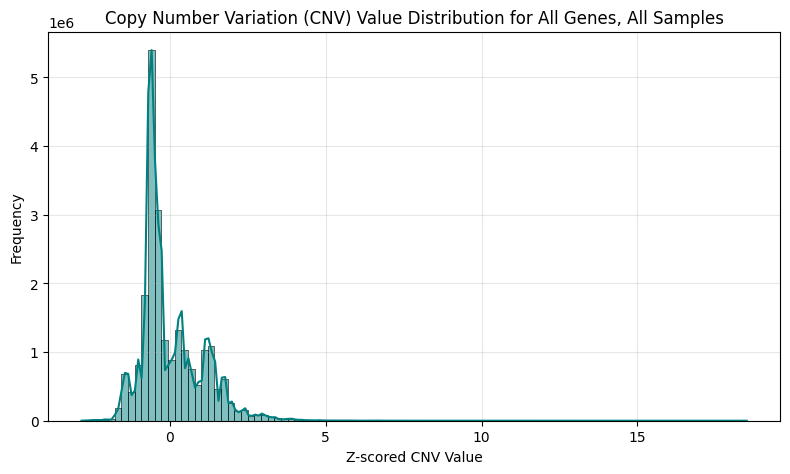

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(cnv_values.values, bins=100, kde=True, color="teal")
plt.title("Copy Number Variation (CNV) Value Distribution for All Genes, All Samples")
plt.xlabel("Z-scored CNV Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

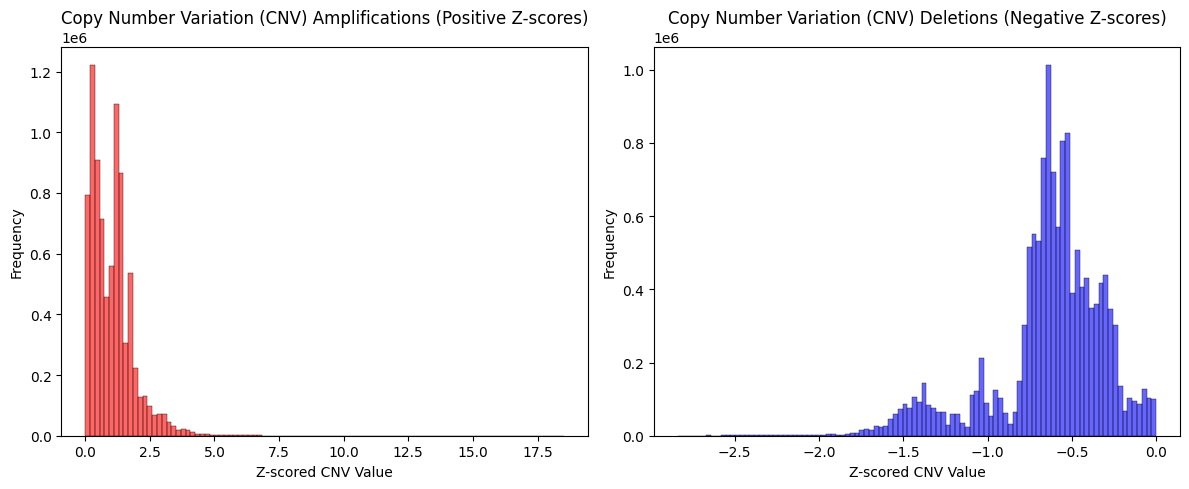

In [10]:
# === Split amplifications and deletions ===
amplifications = cnv_values[cnv_values > 0]
deletions = cnv_values[cnv_values < 0]

# === Plot ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(amplifications, bins=100, color="red", alpha=0.6)
plt.title("Copy Number Variation (CNV) Amplifications (Positive Z-scores)")
plt.xlabel("Z-scored CNV Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(deletions, bins=100, color="blue", alpha=0.6)
plt.title("Copy Number Variation (CNV) Deletions (Negative Z-scores)")
plt.xlabel("Z-scored CNV Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### SNV files

In [ ]:
snv_files = glob(os.path.join(paths["snv"], "**/*.maf*"))
print(f"Found {len(snv_files)} SNV files")

if snv_files:
    df_snv = pd.read_csv(snv_files[0], sep="\t", comment="#", low_memory=False)
    print(df_snv)
else:
    print("No SNV files found")

# Addition of case ID column to snv dataframe
df_snv["case_id"] = df_snv["Tumor_Sample_Barcode"].str.extract(r"(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4})")
print(df_snv.info())
df_snv.head()

In [ ]:
# Define columns to keep
keep_cols = [
    "case_id", "Hugo_Symbol", "Entrez_Gene_Id", "Chromosome", "Start_Position", "End_Position",
    "Strand", "Variant_Classification", "Variant_Type",
    "Reference_Allele", "Tumor_Seq_Allele1", "Tumor_Seq_Allele2",
    "Tumor_Sample_Barcode", "COSMIC", "hotspot", "callers"
]

# Keep only these columns (ignore missing ones)
df_snv_filtered = df_snv[keep_cols].copy()

# Drop rows with NA gene names or sample IDs
df_snv_filtered = df_snv_filtered.dropna(subset=["Hugo_Symbol", "Tumor_Sample_Barcode"])

print(f" Columns retained: {df_snv_filtered.shape[1]}")
df_snv_filtered

### SNV: mutation one hot encoding + tmour burden calculation + RNA-seq alignment

In [ ]:

# Load RNA-seq sample IDs
df_rna_norm = pd.read_csv("/scratch3/users/chantelle/tcga_cesc_data/processed/merged_tcga_cesc_rna_log2TPM_filtered_zscore.tsv", sep= "\t")
rna_case_ids = set(df_rna_norm.columns[1:])  # exclude gene_id column

# Find SNV files recursively
snv_files = glob(os.path.join(paths["snv"], "**/*.maf*"))
print(f"Found {len(snv_files)} SNV files")
if not snv_files:
    raise FileNotFoundError(" No SNV files found — check your path or file extensions.")

# Read and combine all SNV files
df_list = []
for f in tqdm(snv_files, desc=" Reading SNV MAF files"):
    df = pd.read_csv(f, sep="\t", comment="#", low_memory=False)
    if "Tumor_Sample_Barcode" not in df.columns:
        continue  # skip malformed files
    df["case_id"] = df["Tumor_Sample_Barcode"].str.extract(r"(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4})")
    df = df[["Hugo_Symbol", "Variant_Classification", "case_id"]].dropna(subset=["case_id"])
    df_list.append(df)

# Combine all into a single dataframe
df_snv = pd.concat(df_list, ignore_index=True)
print(f" Combined SNV data shape: {df_snv.shape}")

# Keep only non-silent mutations (optional, improves biological relevance)
nonsilent_classes = [
    "Missense_Mutation", "Nonsense_Mutation", "Frame_Shift_Del", "Frame_Shift_Ins",
    "Splice_Site", "Translation_Start_Site", "In_Frame_Del", "In_Frame_Ins"
]
df_snv_filtered = df_snv[df_snv["Variant_Classification"].isin(nonsilent_classes)]

# Create mutation presence matrix (1 = mutated, 0 = not mutated)
snv_matrix = (
    df_snv_filtered
    .groupby(["Hugo_Symbol", "case_id"])
    .size()
    .unstack(fill_value=0)
)
snv_matrix = (snv_matrix > 0).astype(int)

# Calculate Tumor Mutational Burden (TMB)
tmb = df_snv_filtered.groupby("case_id").size().reset_index(name="TMB")

# --- ALIGNMENT CHECK WITH RNA DATA ---
snv_cases = set(snv_matrix.columns)
common_cases = snv_cases.intersection(rna_case_ids)
missing_in_snv = rna_case_ids - snv_cases
missing_in_rna = snv_cases - rna_case_ids

print(f"\n Alignment Summary:")
print(f" - Common cases: {len(common_cases)}")
print(f" - Missing in SNV: {len(missing_in_snv)}")
print(f" - Missing in RNA: {len(missing_in_rna)}")

#  filter to shared cases only
snv_matrix = snv_matrix[sorted(common_cases)]
df_rna = df_rna_norm[["gene_id", "gene_type" ] + sorted(common_cases)]

# Save outputs
snv_matrix.to_csv("/tcga_cesc_data/processed/snv_matrix.csv")
tmb.to_csv("/tcga_cesc_data/processed/tmb_summary.csv", index=False)
df_rna.to_csv("/tcga_cesc_data/processed/rna_matrix_filtered.csv", index=False)

print("\n SNV and RNA-seq data successfully aligned and saved!")
print(f"Final SNV matrix shape: {snv_matrix.shape}")
print(f"Final RNA matrix shape: {df_rna.shape}")


/tmp/ipykernel_431893/3446478613.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_rna_norm = pd.read_csv("/scratch3/users/chantelle/tcga_cesc_data/processed/merged_tcga_cesc_rna_log2TPM_filtered_zscore.tsv", sep= "\t")


Found 287 SNV files


📥 Reading SNV MAF files: 100%|██████████| 287/287 [00:14<00:00, 19.68it/s]


✅ Combined SNV data shape: (68787, 3)

🔗 Alignment Summary:
 - Common cases: 277
 - Missing in SNV: 331
 - Missing in RNA: 9

✅ SNV and RNA-seq data successfully aligned and saved!
Final SNV matrix shape: (14492, 277)
Final RNA matrix shape: (33335, 279)


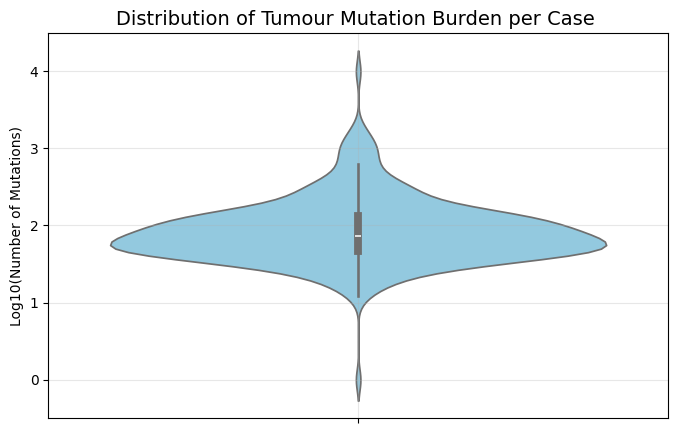

In [30]:
plt.figure(figsize=(8,5))
sns.violinplot(y=np.log10(df_tmb_summary['TMB']), color="skyblue", inner="box")
plt.title("Distribution of Tumour Mutation Burden per Case ", fontsize=14)
plt.ylabel("Log10(Number of Mutations)")
plt.grid(alpha=0.3)
plt.show()


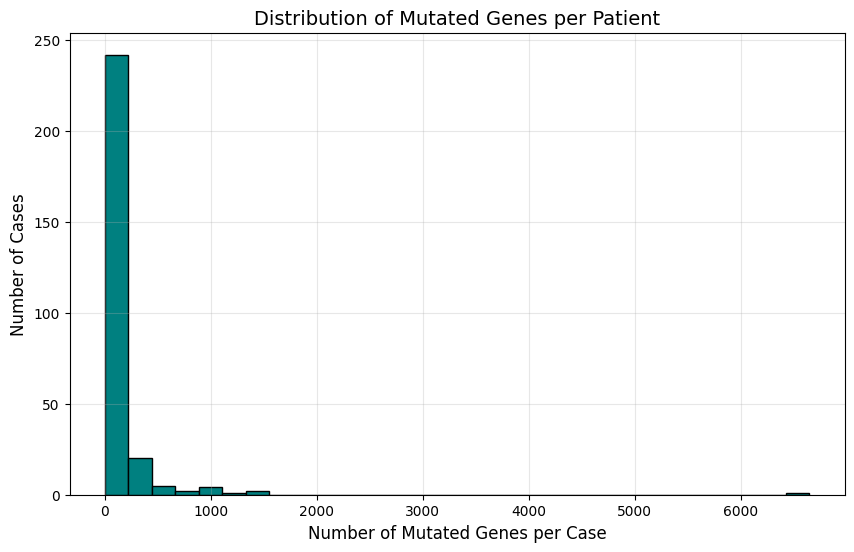

In [ ]:


# Plot distribution
plt.figure(figsize=(10,6))
plt.hist(df_snv_matrix.sum(axis=0), bins=30, color='teal', edgecolor='black')
plt.title("Distribution of Mutated Genes per Patient", fontsize=14)
plt.xlabel("Number of Mutated Genes per Case", fontsize=12)
plt.xticks()
plt.ylabel("Number of Cases", fontsize=12)
plt.grid(alpha=0.3)
plt.show()



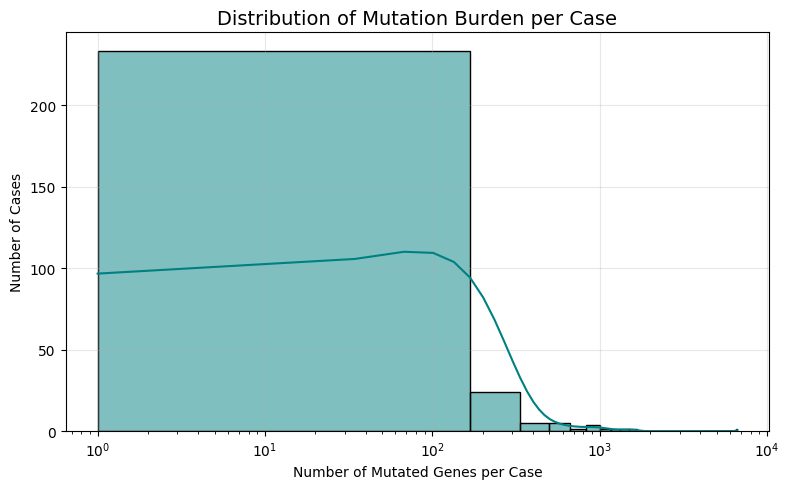

In [31]:
plt.figure(figsize=(8,5))
sns.histplot(df_snv_matrix.sum(axis=0), bins=40, kde=True, color="teal")
plt.xscale("log")
plt.title("Distribution of Mutation Burden per Case", fontsize=14)
plt.xlabel("Number of Mutated Genes per Case")
plt.ylabel("Number of Cases")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Hypermutated cases: 5 out of 277 total


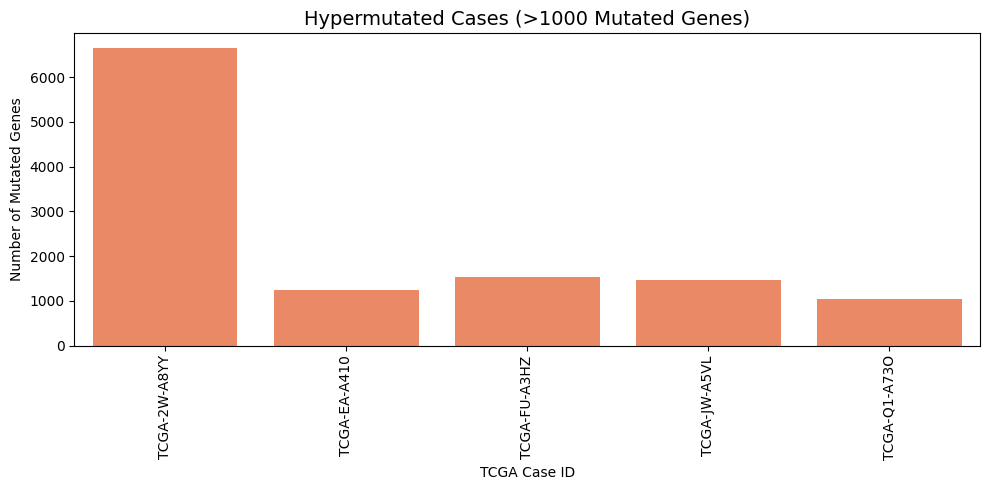

In [33]:
mutation_burden = df_snv_matrix.sum(axis=0)
hypermutated_cases = mutation_burden[mutation_burden > 1000]
print(f"Hypermutated cases: {len(hypermutated_cases)} out of {len(mutation_burden)} total")

plt.figure(figsize=(10,5))
sns.barplot(x=hypermutated_cases.index, y=hypermutated_cases.values, color="coral")
plt.xticks(rotation=90)
plt.title("Hypermutated Cases (>1000 Mutated Genes)", fontsize=14)
plt.xlabel("TCGA Case ID")
plt.ylabel("Number of Mutated Genes")
plt.tight_layout()
plt.show()


### Transcriptome files

In [ ]:
rna_files = glob(os.path.join(paths["transcriptome"], "*/**.rna_seq.augmented_star_gene_counts.tsv"))
print(f"Found {len(rna_files)} RNA-seq files")

if rna_files:
    df_rna = pd.read_csv(rna_files[0], sep="\t", comment="#")
    df_rna.rename(columns={
        "tpm_unstranded": "TPM",
        "fpkm_unstranded": "FPKM",
        "fpkm_uq_unstranded": "FPKMUQ"
    }, inplace=True)
    print(df_rna.shape)
else:
	print("No RNA-seq files found.")
# Remove summary rows that start with "N_"
df_rna = df_rna[~df_rna["gene_id"].str.startswith("N_")]

# Keep only relevant columns
df_rna_filtered = df_rna[["gene_id", "gene_name", "gene_type", "TPM"]].copy()
# Remove missing or zero TPMs
df_rna_filtered = df_rna_filtered[df_rna_filtered["TPM"].notna()]
df_rna_filtered = df_rna_filtered[df_rna_filtered["TPM"] > 0]
df_rna_filtered


### mRNA normalisation

In [ ]:


# === Define paths ===
paths = {"output": "/scratch3/users/chantelle/tcga_cesc_data/processed/merged_tcga_cesc_rna_log2TPM_filtered_zscore.tsv"}

# === Load GDC Sample Sheet ===
sample_sheet = pd.read_csv(paths["sample_sheet"], sep="\t")
print(" Loaded GDC sample sheet:", sample_sheet.shape)
print(sample_sheet.head(3))

# Map: File ID (UUID) → Case ID (TCGA-XX-XXXX)
uuid_to_caseid = dict(zip(sample_sheet["File ID"], sample_sheet["Case ID"]))
print(f" Created mapping for {len(uuid_to_caseid)} files")

# === Collect all RNA-seq files ===
rna_files = glob(os.path.join(paths["transcriptome"], "**/*.rna_seq.augmented_star_gene_counts.tsv"), recursive=True)
print(f"Found {len(rna_files)} RNA-seq files")

# === Regular expression for UUIDs ===
uuid_pattern = re.compile(r"[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}")

rna_dfs = []
annotation_ref = None
unmatched_files = []

# === Loop through each RNA-seq file ===
for file_path in rna_files:
    filename = os.path.basename(file_path)
    uuids = uuid_pattern.findall(file_path)

    case_id = None
    for uid in uuids:
        if uid in uuid_to_caseid:
            case_id = uuid_to_caseid[uid]
            break

    if case_id is None:
        unmatched_files.append(filename)
        continue

    try:
        # === Load RNA file ===
        df = pd.read_csv(file_path, sep="\t", comment="#")
        df = df[~df["gene_id"].astype(str).str.startswith("N_")]  # remove summary rows

        # Rename columns for consistency
        df.rename(columns={
            "tpm_unstranded": "TPM",
            "fpkm_unstranded": "FPKM",
            "fpkm_uq_unstranded": "FPKMUQ"
        }, inplace=True)

        # Keep relevant columns
        df = df[["gene_id", "gene_name", "gene_type", "TPM"]].copy()
        df = df[df["TPM"].notna()]
        df = df[df["TPM"] > 0]

        # Log2 normalize TPM values
        df[case_id] = np.log2(df["TPM"] + 1)

        # Store annotation from the first file
        if annotation_ref is None:
            annotation_ref = df[["gene_id", "gene_name", "gene_type"]].copy()

        # Keep only gene_id and case_id expression column
        df = df[["gene_id", case_id]]
        rna_dfs.append(df)

    except Exception as e:
        print(f" Could not process {filename}: {e}")

print(f"\n Successfully loaded {len(rna_dfs)} RNA files with case IDs")
if unmatched_files:
    print(f" {len(unmatched_files)} files had no Case ID match:")
    print(unmatched_files[:10])

# === Merge all normalized TPM matrices ===
print("\n Merging all normalized TPM matrices...")
df_merged = rna_dfs[0]
for df in rna_dfs[1:]:
    df_merged = pd.merge(df_merged, df, on="gene_id", how="outer")

# === Add annotation columns ===
df_final = pd.merge(annotation_ref, df_merged, on="gene_id", how="left")

# === Fill missing values with 0 ===
df_final = df_final.fillna(0)

# === Filter lowly expressed genes ===
sample_cols = [col for col in df_final.columns if col.startswith("TCGA-")]
expression_data = df_final[sample_cols]
filter_mask = (expression_data >= 1).sum(axis=1) >= (0.2 * len(sample_cols))
df_filtered = df_final.loc[filter_mask].reset_index(drop=True)

print(f" Filtered out lowly expressed genes: {df_final.shape[0] - df_filtered.shape[0]} removed")
df_filtered = df_filtered[df_filtered["gene_type"] == "protein_coding"]
print(f" Retained protein-coding genes: {df_filtered.shape[0]}")

# === Z-score normalization per gene ===
zscore_data = expression_data.apply(lambda x: (x - x.mean()) / x.std(ddof=0), axis=1)
zscore_data.columns = [f"{col}_zscore" for col in zscore_data.columns]

# Combine with filtered data
df_filtered = pd.concat([df_filtered, zscore_data], axis=1)

# === Save output ===
os.makedirs(os.path.dirname(paths["output"]), exist_ok=True)
df_filtered.to_csv(paths["output"], sep="\t", index=False)

print(f"\nFinal RNA-seq matrix saved to: {paths['output']}")
print(f"Shape after filtering & z-scoring: {df_filtered.shape}")


 Loaded GDC sample sheet: (19168, 11)
                                File ID  \
0  9abf4188-46e4-4fbe-95ee-e47e8273f28a   
1  da37d9e5-ac0b-4ab1-980f-6304c32d3a2b   
2  7b3b3602-ca5d-4644-b00e-277ada91212a   

                                           File Name  \
0  5d2bf962-0834-4127-b157-b02d42d8ab1c.wxs.MuTec...   
1  b06c60f6-e2a8-43ca-bc76-41fa163c2310.methylati...   
2  TCGA-CESC.ea6e2ed0-e98e-4c32-b88b-5e5c3559771d...   

                 Data Category                   Data Type Project ID  \
0  Simple Nucleotide Variation  Annotated Somatic Mutation  TCGA-CESC   
1              DNA Methylation      Methylation Beta Value  TCGA-CESC   
2         Structural Variation           Transcript Fusion  TCGA-CESC   

                      Case ID                           Sample ID  \
0  TCGA-EK-A2H0, TCGA-EK-A2H0  TCGA-EK-A2H0-10A, TCGA-EK-A2H0-01A   
1                TCGA-EK-A2H0                    TCGA-EK-A2H0-01A   
2                TCGA-EK-A2RN                    TCGA-EK-A2RN-01

In [25]:
# read processed rna dataset 
df_rna_norm = pd.read_csv("/scratch3/users/chantelle/tcga_cesc_data/processed/merged_tcga_cesc_rna_log2TPM_filtered_zscore.tsv", sep= "\t", low_memory= False)
# keep only protein coding genes
df_rna_norm = df_rna_norm[df_rna_norm["gene_type"] == "protein_coding"]

# === Filter lowly expressed genes ===
sample_cols = [col for col in df_rna_norm.columns if col.startswith("TCGA-")]
expression_data = df_rna_norm[sample_cols]
filter_mask = (expression_data >= 1).sum(axis=1) >= (0.2 * len(sample_cols))
df_rna_norm = df_rna_norm.loc[filter_mask].reset_index(drop=True)

df_rna_norm.to_csv("/scratch3/users/chantelle/tcga_cesc_data/processed/merged_tcga_cesc_rna_log2TPM_filtered_zscore.tsv", sep = "\t", index= False)

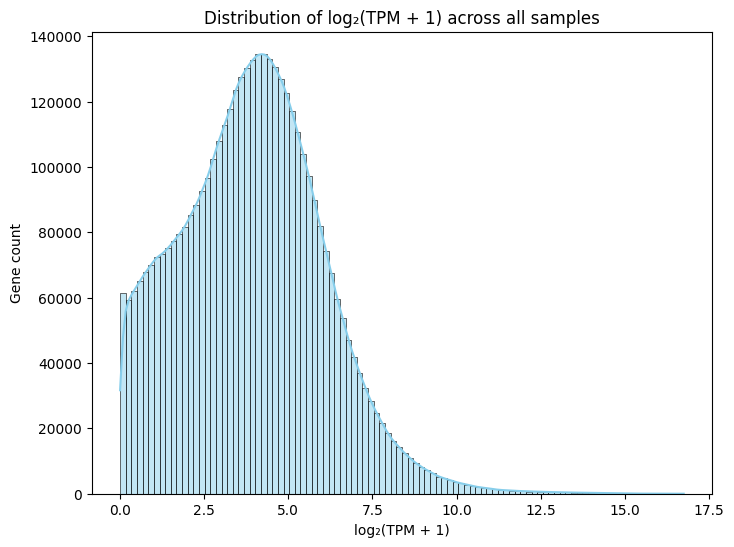

In [ ]:


sample_cols = [c for c in df_rna_norm.columns if c.startswith("TCGA-") and not c.endswith("_zscore")]

# Combine all samples' TPMs into one Series
tpm_values = df_rna_norm[sample_cols].values.flatten()

plt.figure(figsize=(8,6))
sns.histplot(tpm_values, bins=100, color="skyblue", kde=True)
plt.title("Distribution of log₂(TPM + 1) across all samples")
plt.xlabel("log₂(TPM + 1)")
plt.ylabel("Gene count")
plt.show()



### Methylation data Prepartion

In [81]:
methylation_files = glob(os.path.join(paths["methylation"], "**/*.level3betas.txt"))
print(f"Found {len(methylation_files)} .txt files")

df_methylation = pd.read_csv(methylation_files[300], sep="\t", comment="#")
print(df_methylation)

Found 311 .txt files
        cg00000029  0.31477511023934
0       cg00000108          0.966564
1       cg00000109          0.914262
2       cg00000165          0.469453
3       cg00000236          0.878243
4       cg00000289               NaN
...            ...               ...
486421   rs9363764               NaN
486422    rs939290               NaN
486423    rs951295               NaN
486424    rs966367               NaN
486425   rs9839873               NaN

[486426 rows x 2 columns]


In [ ]:


# ===============================
# STEP 1: Load sample sheet
# ===============================
sample_sheet = pd.read_csv(paths["sample_sheet"], sep="\t")
print(f"Sample sheet loaded: {sample_sheet.shape}")

# ===============================
# STEP 2: Locate methylation files
# ===============================
methylation_files = glob(os.path.join(paths["methylation"], "**/*.level3betas.txt"), recursive=True)
print(f"Found {len(methylation_files)} methylation files")

# ===============================
# STEP 3: Match by File Name → Case ID
# ===============================
file_to_case = dict(zip(sample_sheet["File Name"], sample_sheet["Case ID"]))
matched_files, unmatched_files = [], []

for f in methylation_files:
    fname = os.path.basename(f)
    case_id = file_to_case.get(fname)
    if case_id:
        matched_files.append((f, case_id))
    else:
        unmatched_files.append(fname)

print(f" Matched {len(matched_files)} files to Case IDs")
if unmatched_files:
    print(f" Unmatched: {len(unmatched_files)} (showing 5 examples)")
    print(unmatched_files[:5])

# ===============================
# STEP 4: Define read function
# ===============================
def read_methylation_file(args):
    file_path, case_id = args
    try:
        df = pd.read_csv(file_path, sep="\t", comment="#", names=["probe_id", case_id])
        return df
    except Exception as e:
        print(f" Error reading {file_path}: {e}")
        return None

# ===============================
# STEP 5: Process in chunks
# ===============================
n_workers = min(28, cpu_count())
chunk_size = 25

chunks = [matched_files[i:i + chunk_size] for i in range(0, len(matched_files), chunk_size)]
intermediate_paths = []

print(f" Processing {len(chunks)} chunks of ~{chunk_size} files each using {n_workers} CPUs")

for chunk_idx, chunk in enumerate(tqdm(chunks, desc="Processing chunks")):
    chunk_path = os.path.join(paths["output"], f"methylation_chunk_{chunk_idx + 1}.tsv")

    # Skip existing chunks
    if os.path.exists(chunk_path):
        print(f"⏭ Skipping chunk {chunk_idx + 1} (already exists)")
        intermediate_paths.append(chunk_path)
        continue

    with Pool(processes=n_workers) as pool:
        dfs = pool.map(read_methylation_file, chunk)

    dfs = [df for df in dfs if df is not None]

    # Merge all DataFrames in the chunk
    df_chunk = dfs[0]
    for df in dfs[1:]:
        df_chunk = pd.merge(df_chunk, df, on="probe_id", how="outer")

    # Save to disk and free memory
    df_chunk.to_csv(chunk_path, sep="\t", index=False)
    intermediate_paths.append(chunk_path)
    del df_chunk, dfs
    gc.collect()  #  Frees memory
    print(f" Saved chunk {chunk_idx + 1}/{len(chunks)}")

# ===============================
# STEP 6: Incremental merge of chunks
# ===============================
print("\n Incrementally merging all chunks (low-memory mode)...")

out_path = os.path.join(paths["output"], "merged_tcga_cesc_methylation_incremental.tsv")

df_final = pd.read_csv(intermediate_paths[0], sep="\t")

for p in tqdm(intermediate_paths[1:], desc="Final merge"):
    df_temp = pd.read_csv(p, sep="\t")
    df_final = pd.merge(df_final, df_temp, on="probe_id", how="outer")

    # Save intermediate result after each merge
    df_final.to_csv(out_path, sep="\t", index=False)

    # Free memory
    del df_temp
    gc.collect()

print(f" Incremental merge complete: {df_final.shape}")

# ===============================
# STEP 7: Clean missing values
# ===============================
na_threshold = 0.3 * (df_final.shape[1] - 1)
df_final = df_final.dropna(thresh=na_threshold, subset=df_final.columns[1:])
df_final.iloc[:, 1:] = df_final.iloc[:, 1:].apply(lambda x: x.fillna(x.mean()), axis=0)
print(" Missing values filled with column means")

# ===============================
# STEP 8: Z-score normalization
# ===============================
df_final.iloc[:, 1:] = df_final.iloc[:, 1:].apply(
    lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-8), axis=1
)
print(" Z-score normalization complete")

# ===============================
# STEP 9: Dimensionality reduction
# ===============================
variance = df_final.iloc[:, 1:].var(axis=1)
top_probes = variance.nlargest(10000).index
df_methylation_reduced = df_final.loc[top_probes].reset_index(drop=True)
print(f" Reduced methylation matrix shape: {df_methylation_reduced.shape}")

# ===============================
# STEP 10: Save outputs
# ===============================
out_full = os.path.join(paths["output"], "merged_tcga_cesc_methylation_zscore.tsv")
out_reduced = os.path.join(paths["output"], "merged_tcga_cesc_methylation_top10k.tsv")

df_final.to_csv(out_full, sep="\t", index=False)
df_methylation_reduced.to_csv(out_reduced, sep="\t", index=False)

print(f"\n Full matrix saved to: {out_full}")
print(f" Reduced top-10k matrix saved to: {out_reduced}")
print(" All steps completed successfully with memory optimization!")


Sample sheet loaded: (19168, 11)
Found 311 methylation files
✅ Matched 306 files to Case IDs
⚠️ Unmatched: 5 (showing 5 examples)
['953940b4-a5c6-4446-ae1b-084bc1c7ff65.methylation_array.sesame.level3betas.txt', 'e300f979-78c3-48bb-98d2-3770f7181118.methylation_array.sesame.level3betas.txt', '2708c59a-0450-47a4-841d-b0e1c3f14c84.methylation_array.sesame.level3betas.txt', 'c8f2e91a-4a37-4ed0-8e5b-11e52c1e65d1.methylation_array.sesame.level3betas.txt', 'b5581a3e-d18f-4868-a8c2-7cde749c60ac.methylation_array.sesame.level3betas.txt']
 Processing 13 chunks of ~25 files each using 4 CPUs


Processing chunks: 100%|██████████| 13/13 [00:00<00:00, 1568.69it/s]

⏭ Skipping chunk 1 (already exists)
⏭ Skipping chunk 2 (already exists)
⏭ Skipping chunk 3 (already exists)
⏭ Skipping chunk 4 (already exists)
⏭ Skipping chunk 5 (already exists)
⏭ Skipping chunk 6 (already exists)
⏭ Skipping chunk 7 (already exists)
⏭ Skipping chunk 8 (already exists)
⏭ Skipping chunk 9 (already exists)
⏭ Skipping chunk 10 (already exists)
⏭ Skipping chunk 11 (already exists)
⏭ Skipping chunk 12 (already exists)
⏭ Skipping chunk 13 (already exists)

🔁 Incrementally merging all chunks (low-memory mode)...



Final merge:  50%|█████     | 6/12 [39:52<48:10, 481.71s/it]

In [ ]:
chunk_paths = sorted(glob(os.path.join(temp_dir, "chunk_*.tsv")))
    merged = pd.read_csv(chunk_paths[0], sep="\t")

    for p in chunk_paths[1:]:
        df_temp = pd.read_csv(p, sep="\t")
        merged = pd.merge(merged, df_temp, on="probe_id", how="outer")
        merged.to_csv(out_path, sep="\t", index=False)
        print(f" Merged {p.split('/')[-1]} into final matrix")

print(f" Incremental merge complete. Output saved to: {out_path}")

In [ ]:

chunk_paths = glob(os.path.join("/scratch3/users/chantelle/tcga_cesc_data/processed/methylation_chunk_*.tsv"))
print(len(chunk_paths))
merged = pd.read_csv(chunk_paths[0], sep="\t")

for p in chunk_paths[1:]:
    df_temp = pd.read_csv(p, sep="\t")
    merged = pd.merge(merged, df_temp, on="probe_id", how="outer")
merged.to_csv(out_path, sep="\t", index=False)  
print(f" Incremental merge complete. Output saved to: {out_path}")

13


: 

### WSI Preperation

In [3]:
wsi_files = glob(os.path.join(paths["wsi"], "**/*.svs")) + \
            glob(os.path.join(paths["cnv"], "**/*.svs")) + \
            glob(os.path.join(paths["clinical"], "**/*.svs")) + \
            glob(os.path.join(paths["transcriptome"], "**/*.svs")) + \
            glob(os.path.join(paths["snv"], "**/*.svs"))
print(f"Found {len(wsi_files)} .svs files")


Found 1457 .svs files


In [4]:

# Get just the base filenames (without paths)
wsi_basenames = [os.path.basename(f) for f in wsi_files]

# Count unique ones
unique_wsi = set(wsi_basenames)
print(f"Total unique .svs filenames: {len(unique_wsi)}")

# (Optional) See how many duplicates exist
duplicates = [x for x in wsi_basenames if wsi_basenames.count(x) > 1]
print(f"Duplicate filenames found: {len(set(duplicates))}")

# (Optional) Print examples of duplicates
if duplicates:
    print("Example duplicate filenames:")
    print(list(set(duplicates))[:10])


Total unique .svs filenames: 603
Duplicate filenames found: 574
Example duplicate filenames:
['TCGA-VS-A9UM-01A-01-TS1.7FDB3611-F30B-4AEE-8D99-D63EC97819B7.svs', 'TCGA-ZJ-AB0I-01A-01-TSA.7D72E423-76CD-45B7-B17A-BBF669C80834.svs', 'TCGA-VS-A94Y-01Z-00-DX1.0A4D4E4D-DD01-4692-BE70-1D08CC648361.svs', 'TCGA-JW-A5VI-01A-01-TS1.A61CF116-0BCD-4987-A4E6-D9243319862B.svs', 'TCGA-JW-A5VL-01Z-00-DX1.93E521AE-1E55-4FBF-A298-78C08ABCB076.svs', 'TCGA-DS-A0VN-01A-02-TSB.d6361633-27b0-4b65-9d48-839e01435849.svs', 'TCGA-LP-A4AV-01Z-00-DX1.42D4222F-9534-48B5-8478-2BA6E25F32BA.svs', 'TCGA-FU-A5XV-01A-01-TS1.65C1837A-5299-4DF8-B341-3BD1D950D48F.svs', 'TCGA-EA-A43B-01A-08-TSH.DED6ACB8-7726-439E-96BC-17FC5C8C52D4.svs', 'TCGA-VS-A8QC-01Z-00-DX1.D9F4062C-0438-4D76-9BB2-674138A949BD.svs']


In [19]:


# Open the first WSI
slide = openslide.OpenSlide(wsi_files[47])
print(f"WSI dimensions: {slide.dimensions}")  # (width, height)

# Generate a small thumbnail (e.g., 512x512 pixels)
thumbnail = slide.get_thumbnail((512, 512))

# Define output path
output_path = "/scratch3/users/chantelle/tcga_cesc_data/wsi/ref_thumbnail.png"

# Save as PNG (or .jpg)
thumbnail.save(output_path)

print(f"Thumbnail saved to: {output_path}")


WSI dimensions: (19919, 14620)
Thumbnail saved to: /scratch3/users/chantelle/tcga_cesc_data/wsi/ref_thumbnail.png


In [ ]:
from PIL import Image
from IPython.display import display

img = Image.open("/scratch3/users/chantelle/tcga_cesc_data/processed/ph_out/pointclouds/TCGA-4J-AA1J-01Z-00-DX1.8E768211-46FC-45A4-8689-6DDEA0198D43_patches_pc.npy")
# thumbnail = img.get_thumbnail((256, 256))
display(img)
